In [17]:
import nibabel                      as nib
import nibabel.freesurfer.mghformat as mgh
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

In [7]:
from scipy import ndimage

def read_mgz_file(filepath):
    """Read and load volume"""
    # Read file
    scan = mgh.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def convertersize(volume):
    """convertersize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 256
    desired_width = 256
    desired_height = 256
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 270, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_mgz_file(path)
    #  convertersize
    volume = convertersize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [8]:
scan = process_scan('Scans_CN/OAS30001_MR_d0129.mgz')

Dimension of the CT scan is: (256, 256, 256)


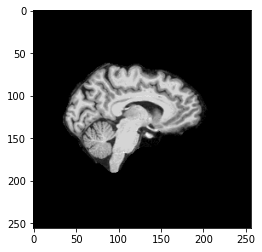

In [9]:
image = scan
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, 120, :]), cmap="gray")

## Reading data

In [16]:
# Folder "Scans_CN" consist of subjects who remained cognitively converters for the whole study.
CN_scan_paths = [
    os.path.join(os.getcwd(), "Scans_CN", x)
    for x in os.listdir("Scans_CN")
]
# Folder "Scans_Converters" consist of subjects who converted from CN to MCI > 0.
converters_scan_paths = [
    os.path.join(os.getcwd(), "Scans_Converters", x)
    for x in os.listdir("Scans_Converters")
]

print("MRI scans for patients remaining CN: " + str(len(CN_scan_paths)))
print("MRI scans for patients converting to AD: " + str(len(converters_scan_paths)))

MRI scans for patients remaining CN: 319
MRI scans for patients converting to AD: 126


In [20]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
CN_scans = np.array([process_scan(path) for path in CN_scan_paths])
#converters_scans = np.array([process_scan(path) for path in converters_scan_paths])

# For the converters assign 1, for the CN subjects assign 0.
CN_labels = np.array([0 for _ in range(len(CN_scans))])
#converters_labels = np.array([1 for _ in range(len(converters_scans))])

MemoryError: Unable to allocate 19.9 GiB for an array with shape (319, 256, 256, 256) and data type float32

In [ ]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((CN_scans[:70], converters_scans[:70]), axis=0)
y_train = np.concatenate((CN_labels[:70], converters_labels[:70]), axis=0)
x_val = np.concatenate((CN_scans[70:], converters_scans[70:]), axis=0)
y_val = np.concatenate((CN_labels[70:], converters_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])